<a href="https://colab.research.google.com/github/Navash914/APS360_ArtificialIntelligenceFundamentals/blob/master/Lab5/Lab_5_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Spam Detection

**Deadline**: Thursday, March 12, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Karthik Bhaskar 

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1bfT5949Jf-LhS374tHjuiXGhfQaN-sBH

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [114]:
found_ham = False
found_spam = False
for line in open('SMSSpamCollection'):
  if found_ham and found_spam:
    break
  msg_type = line.split("\t", 1)[0];
  if (not found_ham and msg_type == "ham"):
    print(line)
    found_ham = True
  if (not found_spam and msg_type == "spam"):
    print(line)
    found_spam = True

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



A spam message is labelled as "spam" at the start of the message.<br>A non-spam message is labelled as "ham" at the start of the message.

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [115]:
ham_count = 0
spam_count = 0
for line in open('SMSSpamCollection'):
  msg_type = line.split("\t", 1)[0];
  if (msg_type == "ham"):
    ham_count += 1
  if (msg_type == "spam"):
    spam_count += 1

print("Number of spam messages: {0}\nNumber of non-spam messages: {1}".format(spam_count, ham_count))

Number of spam messages: 747
Number of non-spam messages: 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Advantages<br>
* Can work with unknown words.
* Can have a deeper understanding of the message as character level is more in-depth than word level.

Disadvantages:<br>
* More expensive computations for training and making predictions.
* Model may not pick up on the 'meaning' of words as it looks simply at the characters that the word consists of.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [0]:
import torchtext

text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

train, valid, test = dataset.split([0.6, 0.2, 0.2])

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating non-spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [0]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [0]:
text_field.build_vocab(train)
#text_field.vocab.stoi
#text_field.vocab.itos

`text_field.vocab.stoi` is a dictionary that represents the mapping of each character to an integer value. `text_field.vocab.itos` is a list where the value of each index corresponds to the character that maps to that integer.

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

`<unk>` represents an unknown value and `<pad>` represents padding to get inputs to the same size (for batching).

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [0]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [0]:
def get_iter(data, batch_size):
  data_iter = torchtext.data.BucketIterator(data,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

  return data_iter                                           

In [121]:
for (i, batch) in enumerate(train_iter, 0):
    if i >= 10:
      break
    print("Batch {0}:".format(i+1))
    print("Batch Size:", len(batch))
    max_inp_len = int(batch.sms[1][0])
    print("Maximum input sequence length:", max_inp_len)
    num_pads = 0
    for inp_len in batch.sms[1]:
      num_pads += max_inp_len - int(inp_len)
    print("Number of <pad> tokens used:", num_pads)
    print()

Batch 1:
Batch Size: 32
Maximum input sequence length: 46
Number of <pad> tokens used: 24

Batch 2:
Batch Size: 32
Maximum input sequence length: 160
Number of <pad> tokens used: 0

Batch 3:
Batch Size: 32
Maximum input sequence length: 80
Number of <pad> tokens used: 51

Batch 4:
Batch Size: 32
Maximum input sequence length: 90
Number of <pad> tokens used: 78

Batch 5:
Batch Size: 32
Maximum input sequence length: 138
Number of <pad> tokens used: 36

Batch 6:
Batch Size: 32
Maximum input sequence length: 147
Number of <pad> tokens used: 29

Batch 7:
Batch Size: 32
Maximum input sequence length: 31
Number of <pad> tokens used: 20

Batch 8:
Batch Size: 32
Maximum input sequence length: 25
Number of <pad> tokens used: 13

Batch 9:
Batch Size: 32
Maximum input sequence length: 152
Number of <pad> tokens used: 19

Batch 10:
Batch Size: 32
Maximum input sequence length: 160
Number of <pad> tokens used: 27



## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [0]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

stoi = text_field.vocab.stoi
inp_len = len(stoi)
ident = torch.eye(inp_len)

In [0]:
def get_one_hot(ch):
  return torch.stack([torch.stack([ident[ch] for ch in sentence]) for sentence in ch])

In [0]:
class RNN(nn.Module):
  def __init__(self, name, inp_size, hidden_size, rnn_type, max_pool):
      super(RNN, self).__init__()
      self.name = name
      self.hidden_size = hidden_size
      self.max_pool = max_pool

      self.rnn = rnn_type(inp_size, hidden_size, batch_first=True)
      self.fc = nn.Linear(hidden_size, 2)

  def forward(self, x):
      x = get_one_hot(x)  # now we have one-hot representation of batch

      h0 = torch.zeros(1, x.size(0), self.hidden_size)

      out,_ = self.rnn(x, h0)

      if self.max_pool:
        out = self.fc(torch.max(out, dim=1)[0])
      else:
        out = self.fc(out[:, -1, :])

      return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [0]:
def get_accuracy(model, data_iter):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """

    acc = 0
    num_items = 0
    for batch in data_iter:
      out = model(batch.sms[0])
      pred = out.max(1, keepdim=True)[1]
      acc += pred.eq(batch.label.view_as(pred)).sum().item()
      num_items += len(batch)

    return acc / num_items

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [0]:
import matplotlib.pyplot as plt

In [0]:
def get_loss(model, data_iter):
  criterion = nn.CrossEntropyLoss()

  total_loss = 0.0
  num_iter = 0
  for batch in data_iter:
    out = model(batch.sms[0])
    loss = criterion(out, batch.label)
    total_loss += loss.item()
    num_iter += 1
  
  return total_loss/num_iter

In [0]:
def train_model(model, train_loader, val_loader, batch_size=32, learning_rate=0.001, num_epochs=5, weight_decay=0.0005):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  epochs, train_acc, val_acc, train_losses, val_losses = [], [], [], [], []
  
  for epoch in range(num_epochs):
      total_loss = 0.0
      total_epoch = 0
      for batch in train_loader:
          optimizer.zero_grad() 

          labels = batch.label
          sentences = batch.sms[0]
          
          out = model(sentences)
          loss = criterion(out, labels)

          total_loss += loss.item()
          loss.backward()
          optimizer.step()

          total_epoch += 1
      
      train_losses.append(total_loss/total_epoch)
      train_acc.append(get_accuracy(model, train_iter))

      val_losses.append(get_loss(model, val_loader))
      val_acc.append(get_accuracy(model, val_loader))

      epochs.append(epoch)
      
      model_path = "model_{}_bs_{}_lr_{}_epoch_{}".format(model.name, batch_size, 
                                                          learning_rate, epoch)

      torch.save(model.state_dict(), model_path)

      print(("Epoch {}: Train acc - {:.4f}, Train loss - {:.4f} || " +
                        "Val acc - {:.4f}, Val loss - {:.4f}").format(
                                                        epoch,
                                                        train_acc[epoch],
                                                        train_losses[epoch],
                                                        val_acc[epoch],
                                                        val_losses[epoch]))
  # Acc
  plt.title("Accuracy")
  plt.plot(epochs, train_acc, label = "train")
  plt.plot(epochs, val_acc, label = "validation")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.show()

  # Loss
  plt.title("Train & Val Loss")
  plt.plot(epochs, train_losses, label = "train")
  plt.plot(epochs, val_losses, label = "validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Epoch 0: Train acc - 0.4852, Train loss - 0.7084 || Val acc - 0.8565, Val loss - 0.6335
Epoch 1: Train acc - 0.5211, Train loss - 0.6715 || Val acc - 0.1570, Val loss - 0.7008
Epoch 2: Train acc - 0.9091, Train loss - 0.6194 || Val acc - 0.8529, Val loss - 0.6455
Epoch 3: Train acc - 0.8763, Train loss - 0.5614 || Val acc - 0.8000, Val loss - 0.6203
Epoch 4: Train acc - 0.9485, Train loss - 0.4618 || Val acc - 0.9677, Val loss - 0.4662
Epoch 5: Train acc - 0.9382, Train loss - 0.3436 || Val acc - 0.9695, Val loss - 0.3423
Epoch 6: Train acc - 0.9326, Train loss - 0.2891 || Val acc - 0.9740, Val loss - 0.1783
Epoch 7: Train acc - 0.9509, Train loss - 0.3645 || Val acc - 0.9274, Val loss - 0.3959
Epoch 8: Train acc - 0.9549, Train loss - 0.2642 || Val acc - 0.9614, Val loss - 0.2734
Epoch 9: Train acc - 0.9540, Train loss - 0.2169 || Val acc - 0.9677, Val loss - 0.1969
Epoch 10: Train acc - 0.9572, Train loss - 0.1752 || Val acc - 0.9605, Val loss - 0.1955
Epoch 11: Train acc - 0.9550, T

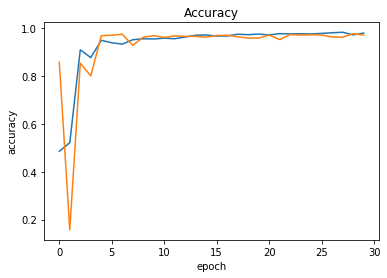

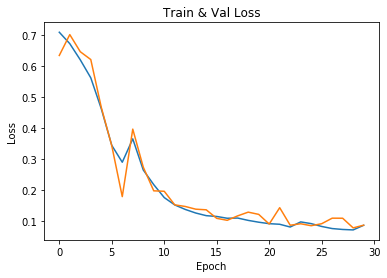

In [139]:
bs = 512
lr = 0.001
ne = 30
rnn_type = nn.RNN # nn.RNN or nn.GRU or nn.LSTM
max_pool = True

model = RNN("rnn", inp_len, inp_len, rnn_type, max_pool)

train_iter = get_iter(train, bs)
val_iter = get_iter(valid, bs)

train_model(model, train_iter, val_iter, bs, lr, ne)

I tuned the batch size and learning rates till I got a decent accuracy. After that, I tried max pooling and that significantly improved the training accuracy as well. The best validation accuracy was 97.5%

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [0]:
def false_positive_rate(model, data):
  data_nospam = torchtext.data.Dataset(
    [e for e in data.examples if e.label == 0],
    data.fields)
  
  false_positive_rate = 1.0 - get_accuracy(model, get_iter(data_nospam, 512))
  print("False positive rate: {0:.2f}%".format(100.0 * false_positive_rate))

def false_negative_rate(model, data):
  data_spam = torchtext.data.Dataset(
    [e for e in data.examples if e.label == 1],
    data.fields)
  
  false_negative_rate = 1.0 - get_accuracy(model, get_iter(data_spam, 512))
  print("False negative rate: {0:.2f}%".format(100.0 * false_negative_rate))

def false_pos_neg_rate(model, data):
  false_positive_rate(model, data)
  false_negative_rate(model, data)

In [141]:
best_model = RNN("best", inp_len, inp_len, nn.RNN, True)

model_path = "model_{}_bs_{}_lr_{}_epoch_{}".format("rnn", 512, 0.001, 28)
state = torch.load(model_path)
best_model.load_state_dict(state)

<All keys matched successfully>

In [144]:
false_pos_neg_rate(best_model, valid)

False positive rate: 1.26%
False negative rate: 9.38%


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

A false negative can lead to the user receiving spam messages in their inbox. This is relatively harmless as the user can simply ignore/delete them. A false positive, however, can lead to the user missing important messages that our algorithm detected as spam, which can be much more harmful than a false negative.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [145]:
test_iter = get_iter(test, 512)
test_acc = get_accuracy(best_model, test_iter)
print("Testing accuracy: {0:.2f}%".format(100.0 * test_acc))

Testing accuracy: 97.76%


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [147]:
false_pos_neg_rate(best_model, test)

False positive rate: 1.24%
False negative rate: 8.84%


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [154]:
msg = "machine learning is sooo cool!"

out = best_model(torch.IntTensor([[text_field.vocab.stoi[c] for c in msg]]))
out = out.detach().numpy()

print("The model is {:.2f}% certain that the msg is spam".format(100.0 * out[0][1]))

The model is -170.87% certain that the msg is spam


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

We can try using word-based filters.

From a dataset of only spam messages, generate a list of the most frequent words in the messages (with some exceptions for common words such as 'is', 'and' etc).

If a new message contains atleast x% of the top y most frequent words (eg, the message contains 30% of the top 50 words in the generated list), then mark the message as spam.